In [143]:
import seaborn as sn
import pandas as pd
import json, os

# import torch
# import torch.nn as nn
# from torch.nn.utils.rnn import pad_sequence
# from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
# from torch.optim import Adam
# from transformers import get_linear_schedule_with_warmup
# from torch.nn.utils import clip_grad_norm_
# from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
# from transformers import AutoTokenizer, AutoModel

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM, SimpleRNN
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Masking
from tensorflow.keras.layers import Embedding, MaxPool1D
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.layers import Bidirectional, BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.initializers import glorot_uniform, RandomUniform, lecun_uniform, Constant, TruncatedNormal
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D, GlobalMaxPool1D, Flatten
import tensorflow.keras.backend as K
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, GlobalMaxPool1D
from keras_preprocessing.text import tokenizer_from_json
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Layer

import numpy as np
import csv
from transformers import AutoTokenizer, TFAutoModel, TFGPT2LMHeadModel
import matplotlib.pyplot as plt
import random
from collections import OrderedDict
import time
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, \
roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
import random

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from collections import defaultdict
from imblearn.under_sampling import RandomUnderSampler

from sklearn.utils import shuffle
from tqdm.notebook import tqdm


Define method name and root path of the repository

In [144]:
method = "forSequence"

root_path = os.path.join('..', '..')

In [175]:
embedding_algorithm = "bert" # "bert" # "gpt"

Define specific seeder for all experiments and processes

In [176]:
seed = 123
np.random.seed(seed)
random.seed(seed)
#torch.manual_seed(seed)
tf.random.set_seed(seed)

Define functions for data read and preparation

In [177]:
def dropEmpty(tokens0):
    tokens = []
    for i in range(0, len(tokens0)):
        temp = tokens0[i]
        if temp != []:
            tokens.append(temp)
    return tokens

def listToString(s): 
    
    # initialize an empty string
    str1 = "" 
    
    # traverse in the string 
    count = 0
    for ele in s: 
        if count==0:
            str1 = str1 + ele
        else:
            str1 = str1 + ' ' + ele
        count = count + 1
        #str1 += ele  
    
    # return string  
    return str1

def prepareData(data):
        
    # lowercase
    lines = []
    labels = []
    headlines = []
    for i in range(0, len(data)):
        labels.append(int(data[i][1]))
        headlines.append(data[i][0])
        line = data[i][2:]
        lows = [w.lower() for w in line]
        lines.append(lows)
    
    texts = []
    for i in range(0, len(lines)):
        texts.append(listToString(lines[i]))
    
    return texts, labels, headlines 


Read data and shuffle them

In [178]:
# data_reduced_bert # bigvul_data_reduced
with open(os.path.join(root_path, 'data', 'data_reduced_bert.csv'), newline='', encoding='utf-8') as f:
    reader = csv.reader(f)
    data = list(reader)
data = dropEmpty(data)
random.shuffle(data) # shuffle the data

# Data preparation
texts, labels, headlines = prepareData(data)

Data visualization

Elements in dataset: 4184
2 categories found:
0
1


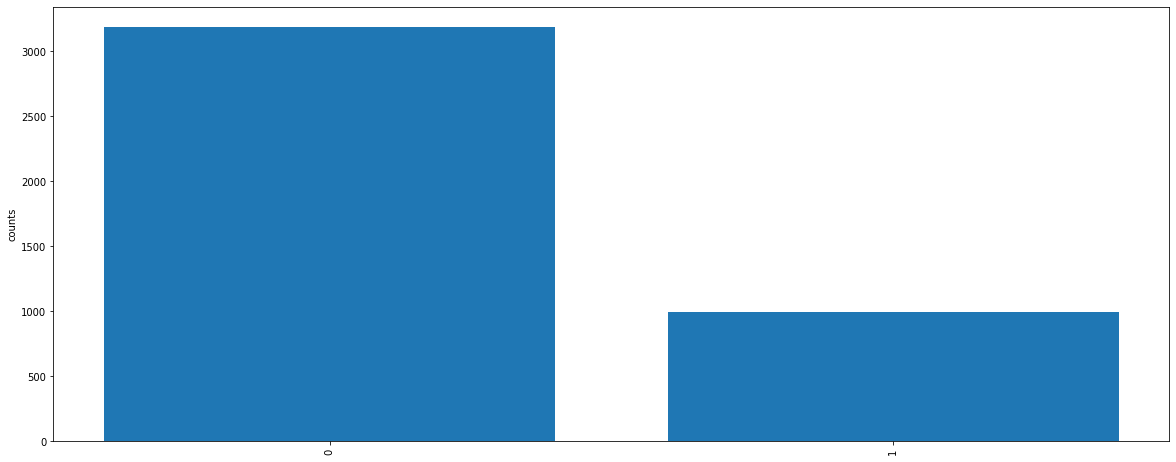

In [179]:
# explore data
n_elements=len(headlines)
print('Elements in dataset:', n_elements)
categories=sorted(list(set(labels))) #set will return the unique different entries
n_categories=len(categories)
print("{} categories found:".format(n_categories))
for category in categories:
    print(category)
    
fig=plt.figure(figsize=(20,8))
lbl, counts = np.unique(labels,return_counts=True)
ticks = range(len(counts))
plt.bar(ticks,counts, align='center')
plt.xticks(ticks,lbl)
plt.xticks(rotation=90)
plt.ylabel('counts')
plt.show()

In [180]:
data = pd.DataFrame(({'Input': texts, 'Is_Vulnerable': labels}))
#data = data[0:100]
data.head()

,Input,Is_Vulnerable
0,class callbackmodule calls strid$ def __init__...,0
1,this_file os path abspath __file__ decode sys ...,0
2,class migration migrations migration dependenc...,0
3,dataset pd strid$ x dataset iloc numid$ values...,1
4,__metaclass__ type ansible_metadata strid$ str...,0


Train test split with seeder

In [181]:
val_ratio = 0.10

#split to train-val-test
# split dataset to train-test sets
### split data into train and test (90% train, 10% test)
shuffle_seeders = [seed, 10, 15, 20, 25, 30, 35, 40, 45, 50]
shuffle_seeder = shuffle_seeders[0]

train_data, test_data = train_test_split(data, test_size=val_ratio, random_state=shuffle_seeder, stratify=data['Is_Vulnerable'])
# print(len(data))
# print(len(train_data))
# print(len(test_data))
# print(len(test_data)+len(train_data))

In [182]:
train_data, val_data = train_test_split(train_data, test_size=val_ratio, random_state=shuffle_seeder, stratify=train_data['Is_Vulnerable'])

Pre-processing step: Under-sampling

In [183]:
sampling = True
if n_categories == 2 and sampling == True:
    # Apply under-sampling with the specified strategy
    class_counts = pd.Series(train_data["Is_Vulnerable"]).value_counts()
    print("Class distribution ", class_counts)

    majority_class = class_counts.idxmax()
    print("Majority class ", majority_class)

    minority_class = class_counts.idxmin()
    print("Minority class ", minority_class)

    target_count = class_counts[class_counts.idxmin()] # int(class_counts.iloc[0] / 2) 
    print("Targeted number of majority class", target_count)

    # under
    sampling_strategy = {majority_class: target_count}        
    rus = RandomUnderSampler(random_state=seed, sampling_strategy=sampling_strategy)

    x_train_resampled, y_train_resampled = rus.fit_resample(np.array(train_data["Input"]).reshape(-1, 1), train_data["Is_Vulnerable"]) 
    print("Class distribution after augmentation", pd.Series(y_train_resampled).value_counts())


    # Shuffle the resampled data while preserving the correspondence between features and labels
    x_train_resampled, y_train_resampled = shuffle(x_train_resampled, y_train_resampled, random_state=seed)

    # rename
    X_train = x_train_resampled
    Y_train = y_train_resampled

    X_train = pd.Series(X_train.reshape(-1))

else:
    X_train = train_data["Input"]
    Y_train = train_data["Is_Vulnerable"]

Class distribution  0    65
1    16
Name: Is_Vulnerable, dtype: int64
Majority class  0
Minority class  1
Targeted number of majority class 16
Class distribution after augmentation 0    16
1    16
Name: Is_Vulnerable, dtype: int64


Choose transformer model

In [184]:
# microsoft/codebert-base-mlm # microsoft/codebert-base

In [185]:
# # PYTORCH
# if embedding_algorithm == "bert":
#     model_variation = "microsoft/codebert-base-mlm"
#     tokenizer = AutoTokenizer.from_pretrained(model_variation, do_lower_case=True) #Tokenizer
#     #bert-base-uncased #bert-base #albert-base-v2 # roberta-base # distilbert-base-uncased #distilbert-base 
#     # Define New tokens for string and numerical i.e., strId$ and numId$
#     new_tokens = ["strId$", "numId$"]
#     for new_token in new_tokens:
#         if new_token not in tokenizer.get_vocab().keys():
#             tokenizer.add_tokens(new_token)
            
#     bert = AutoModel.from_pretrained(model_variation, num_labels=n_categories)

#     bert.resize_token_embeddings(len(tokenizer))

#     embedding_matrix = bert.embeddings.word_embeddings.weight.detach().cpu().numpy()
    
#     num_words = len(embedding_matrix)
#     print(num_words)
#     dim = len(embedding_matrix[0])
#     print(dim)
    
#     sentences = X_train.tolist()
#     sequences = [tokenizer.encode(sente, truncation=True, add_special_tokens=False, return_tensors="pt").numpy() for sente in sentences] # Tokenize the complete sentences

#     lines_pad_x_train = []
#     for seq in sequences:
#         lines_pad_x_train.append(torch.tensor(seq[0]))
    
#     lines_pad_x_train = pad_sequence(lines_pad_x_train, batch_first=True, padding_value=0)
#     max_len = lines_pad_x_train.size()[1]
    
    
#     sentences = val_data["Input"]
#     sequences = [tokenizer.encode(sente, truncation=True, add_special_tokens=False, return_tensors="pt").numpy() for sente in sentences]
#     lines_pad_x_val = []
#     for seq in sequences:
#         lines_pad_x_val.append(torch.tensor(seq[0]))
#     lines_pad_x_val = pad_sequence(lines_pad_x_val, batch_first=True, padding_value=0)
    
#     sentences = test_data["Input"]
#     sequences = [tokenizer.encode(sente, truncation=True, add_special_tokens=False, return_tensors="pt").numpy() for sente in sentences]
#     lines_pad_x_test = []
#     for seq in sequences:
#         lines_pad_x_test.append(torch.tensor(seq[0]))
#     lines_pad_x_test = pad_sequence(lines_pad_x_test, batch_first=True, padding_value=0)
    

In [186]:
def getMaxLen(X):

    # Code for identifying max length of the data samples after tokenization using transformer tokenizer
    
    max_length = 0
    # Iterate over each sample in your dataset
    for i, input_ids in enumerate(X['input_ids']):
        # Calculate the length of the tokenized sequence for the current sample
        length = tf.math.reduce_sum(tf.cast(input_ids != 1, tf.int32)).numpy()
        # Update max_length and max_row if the current length is greater
        if length > max_length:
            max_length = length
            max_row = i

    print("Max length of tokenized data:", max_length)
    print("Row with max length:", max_row)

    #X['input_ids'] = np.delete(X['input_ids'], max_row, axis=0)
    
    return max_length

In [187]:
# TENSORFLOW
if embedding_algorithm == "bert":
    model_variation = "microsoft/codebert-base-mlm"
    tokenizer = AutoTokenizer.from_pretrained(model_variation, do_lower_case=True) #Tokenizer
    #bert-base-uncased #bert-base #albert-base-v2 # roberta-base # distilbert-base-uncased #distilbert-base 
    # Define New tokens for string and numerical i.e., strId$ and numId$
#     new_tokens = ["strId$", "numId$"]
#     for new_token in new_tokens:
#         if new_token not in tokenizer.get_vocab().keys():
#             tokenizer.add_tokens(new_token)
            
    bert = TFAutoModel.from_pretrained(model_variation, num_labels=n_categories)

    #bert.resize_token_embeddings(len(tokenizer))
    
    bert_embeddings = bert.get_input_embeddings()
    embedding_matrix = bert_embeddings.weights[0].numpy()
    
    num_words = embedding_matrix.shape[0]
    print(num_words)
    dim = embedding_matrix.shape[1]
    print(dim)
    
    sentences = X_train.tolist()
    sequences = [tokenizer(sente, truncation=True, add_special_tokens=False, return_tensors="tf") for sente in sentences] # Tokenize the complete sentences

    def padSequences(sequences, max_len):
        lines_pad = []
        for sequence in sequences:
            seq = sequence['input_ids'].numpy()[0]
            if len(seq) < max_len:
                for i in range(len(seq), max_len):
                    seq = np.append(seq, 0)
            lines_pad.append(seq)
        return lines_pad
    
    def get_max_len(sequences):
        max_len = 0

        for seq in sequences:
            if len(seq['input_ids'].numpy()[0]) > max_len:
                max_len = len(seq['input_ids'].numpy()[0])

        return max_len
    
    max_len = get_max_len(sequences)
    print(max_len)
    
    lines_pad_x_train = padSequences(sequences, max_len)
    lines_pad_x_train = [arr.tolist() for arr in lines_pad_x_train]
    lines_pad_x_train = np.array(lines_pad_x_train)
        
    sentences = val_data["Input"]
    sequences = [tokenizer(sente, truncation=True, add_special_tokens=False, return_tensors="tf") for sente in sentences]
    
    lines_pad_x_val = padSequences(sequences, max_len)
    lines_pad_x_val = [arr.tolist() for arr in lines_pad_x_val]
    lines_pad_x_val = np.array(lines_pad_x_val)
    
    sentences = test_data["Input"]
    sequences = [tokenizer(sente, truncation=True, add_special_tokens=False, return_tensors="tf") for sente in sentences]
    
    lines_pad_x_test = padSequences(sequences, max_len)
    lines_pad_x_test = [arr.tolist() for arr in lines_pad_x_test]
    lines_pad_x_test = np.array(lines_pad_x_test)
    

In [188]:
# # PYTORCH
# if embedding_algorithm == "gpt":
#     model_variation = "gpt2" # "microsoft/CodeGPT-small-py-adaptedGPT2" # "gpt2" # "microsoft/CodeGPT-small-py" 
#     tokenizer = AutoTokenizer.from_pretrained(model_variation, do_lower_case=True) #Tokenizer
#     # Define New tokens for string and numerical i.e., strId$ and numId$
#     new_tokens = ["strId$", "numId$"]
#     for new_token in new_tokens:
#         if new_token not in tokenizer.get_vocab().keys():
#             tokenizer.add_tokens(new_token)
            
#     gpt = AutoModel.from_pretrained(model_variation, num_labels=n_categories)

#     gpt.resize_token_embeddings(len(tokenizer))

#     embedding_matrix = gpt.wte.weight.detach().cpu().numpy()
    
#     num_words = len(embedding_matrix)
#     print(num_words)
#     dim = len(embedding_matrix[0])
#     print(dim)
    
#     sentences = X_train.tolist()
#     sequences = [tokenizer.encode(sente, truncation=True, add_special_tokens=False, return_tensors="pt").numpy() for sente in sentences] # Tokenize the complete sentences

#     lines_pad_x_train = []
#     for seq in sequences:
#         lines_pad_x_train.append(torch.tensor(seq[0]))
    
#     lines_pad_x_train = pad_sequence(lines_pad_x_train, batch_first=True, padding_value=0)
#     max_len = lines_pad_x_train.size()[1]
    
    
#     sentences = val_data["Input"]
#     sequences = [tokenizer.encode(sente, truncation=True, add_special_tokens=False, return_tensors="pt").numpy() for sente in sentences]
#     lines_pad_x_val = []
#     for seq in sequences:
#         lines_pad_x_val.append(torch.tensor(seq[0]))
#     lines_pad_x_val = pad_sequence(lines_pad_x_val, batch_first=True, padding_value=0)
    
#     sentences = test_data["Input"]
#     sequences = [tokenizer.encode(sente, truncation=True, add_special_tokens=False, return_tensors="pt").numpy() for sente in sentences]
#     lines_pad_x_test = []
#     for seq in sequences:
#         lines_pad_x_test.append(torch.tensor(seq[0]))
#     lines_pad_x_test = pad_sequence(lines_pad_x_test, batch_first=True, padding_value=0)
    

In [189]:
# TENSORFLOW
if embedding_algorithm == "gpt":
    model_variation = "gpt2" # "microsoft/CodeGPT-small-py-adaptedGPT2" # "gpt2" # "microsoft/CodeGPT-small-py"
    tokenizer = AutoTokenizer.from_pretrained(model_variation, do_lower_case=True) #Tokenizer
    #bert-base-uncased #bert-base #albert-base-v2 # roberta-base # distilbert-base-uncased #distilbert-base 
    # Define New tokens for string and numerical i.e., strId$ and numId$
#     new_tokens = ["strId$", "numId$"]
#     for new_token in new_tokens:
#         if new_token not in tokenizer.get_vocab().keys():
#             tokenizer.add_tokens(new_token)
            
    gpt = TFGPT2LMHeadModel.from_pretrained(model_variation, num_labels=n_categories)

    #gpt.resize_token_embeddings(len(tokenizer))
    
    embedding_matrix = gpt.transformer.wte.weight
    
    num_words = embedding_matrix.shape[0]
    print(num_words)
    dim = embedding_matrix.shape[1]
    print(dim)
    
#     X = tokenizer(
#         text=X_train.tolist(),
#         add_special_tokens=False,
#         max_length=512,
#         truncation=True,
#         padding=True,
#         return_tensors='tf',
#         return_token_type_ids=False,
#         return_attention_mask=True,
#         verbose=True
#     )

#     max_len = getMaxLen(X)
    max_len = 512
    
    sentences = X_train.tolist()
    sequences = [tokenizer.encode(sente, truncation=True, add_special_tokens=False, return_tensors="tf").numpy() for sente in sentences] # Tokenize the complete sentences

    lines_pad_x_train = []
    for seq in sequences:
        lines_pad_x_train.append(seq[0])
    
    lines_pad_x_train = pad_sequences(lines_pad_x_train, padding = 'post', maxlen = max_len)    
    
    sentences = val_data["Input"]
    sequences = [tokenizer.encode(sente, truncation=True, add_special_tokens=False, return_tensors="tf").numpy() for sente in sentences]
    lines_pad_x_val = []
    for seq in sequences:
        lines_pad_x_val.append(seq[0])
    lines_pad_x_val = pad_sequences(lines_pad_x_val, padding = 'post', maxlen = max_len)
    
    sentences = test_data["Input"]
    sequences = [tokenizer.encode(sente, truncation=True, add_special_tokens=False, return_tensors="tf").numpy() for sente in sentences]
    lines_pad_x_test = []
    for seq in sequences:
        lines_pad_x_test.append(seq[0])
    lines_pad_x_test = pad_sequences(lines_pad_x_test, padding = 'post', maxlen = max_len)

    embedding_matrix = embedding_matrix.numpy()

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


50257
768


In [190]:
Y_train = np.array(Y_train)
Y_val = np.array(val_data["Is_Vulnerable"])
Y_test = np.array(test_data["Is_Vulnerable"])
len(Y_train), len(Y_val), len(Y_test)

(32, 9, 10)

In [191]:
# Evaluation functions
def recall_metric(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = (true_positives + K.epsilon()) / (possible_positives + K.epsilon())
        return recall

def precision_metric(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = (true_positives + K.epsilon()) / (predicted_positives + K.epsilon())
        return precision

def f1_metric(y_true, y_pred):

    prec = precision_metric(y_true, y_pred)
    rec = recall_metric(y_true, y_pred)
    f1 = 2*((prec*rec)/(prec+rec+K.epsilon()))
    return f1

def f2_metric(y_true, y_pred):

    prec = precision_metric(y_true, y_pred)
    rec = recall_metric(y_true, y_pred)
    f2 = 5*((prec*rec)/(4*prec+rec+K.epsilon()))
    return f2

Select Hyper-parameters

In [192]:
n_epochs = 100
patience = 10
batch_size = 64
lr = 0.001
optimizer = optimizers.Adam(learning_rate=lr)

In [193]:
# Add attention layer to the deep learning network
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1), 
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1), 
                               initializer='zeros', trainable=True)        
        super(attention, self).build(input_shape)

    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)   
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

def buildLstmWithBahdanauAttention(max_len, top_words, dim, seed, embedding_matrix, optimizer, n_categories):
    model = Sequential()
    kernel_initializer = glorot_uniform()
    model.add(Embedding(input_dim=top_words, output_dim=dim, input_length=max_len, weights=[embedding_matrix], mask_zero=True, trainable=False))
    model.add(GRU(500, activation='tanh', dropout=0.2, return_sequences=True, stateful=False, kernel_constraint=max_norm(3), bias_constraint=max_norm(3), kernel_initializer=kernel_initializer)) 

    model.add(GRU(100, activation='tanh', dropout=0.1, return_sequences=True, stateful=False, kernel_initializer=kernel_initializer))
    model.add(GRU(200, activation='tanh', dropout=0.1, return_sequences=True, stateful=False, kernel_initializer=kernel_initializer))
    model.add(BatchNormalization())

    # Add BahdanauAttention layer before the final output layer
    model.add(attention())

    model.add(Dense(n_categories, activation='softmax', kernel_initializer=kernel_initializer))

    if n_categories > 2:
        model.compile(loss="categorical_crossentropy", optimizer=optimizer)
    else:
        model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=[f1_metric])
    return model

# Deep Learning Models - Classifiers
def buildLstm(max_len, top_words, dim, seed, embedding_matrix, optimizer, n_categories):
    model=Sequential()
    kernel_initializer = glorot_uniform() # glorot_uniform, RandomUniform, lecun_uniform, Constant, TruncatedNormal
    model.add(Embedding(input_dim=top_words, output_dim=dim, input_length=None, weights=[embedding_matrix], mask_zero=True, trainable=False))
    model.add(GRU(500, activation='tanh', dropout=0.2, return_sequences=True, stateful=False, kernel_constraint=max_norm(3), bias_constraint=max_norm(3), kernel_initializer=kernel_initializer)) # , recurrent_constraint=max_norm(3)
    model.add(GRU(100, activation='tanh', dropout=0.1, return_sequences=True, stateful=False, kernel_initializer=kernel_initializer))
    model.add(GRU(200, activation='tanh', dropout=0.1, stateful=False, kernel_initializer=kernel_initializer))
    #model.add(SimpleRNN(300, dropout=0.3, stateful=False))
    #model.add(Bidirectional(LSTM(300, dropout=0.3, stateful=False)))
    #model.add(GRU(300, dropout=0.3, stateful=False))
    model.add(BatchNormalization()) # default momentum=0.99
    model.add(Dense(n_categories, activation='softmax', kernel_initializer=kernel_initializer))
    #model.add(Dropout(0.2))
    
    #optimizer = optimizers.SGD(lr=learning_rate, decay=0.1, momentum=0.2, nesterov=True)
    #optimizer = optimizers.RMSprop(lr=learning_rate, rho=0.9, epsilon=1e-8, decay=0.0)
    #optimizer = optimizers.Adagrad(lr=learning_rate, epsilon=None, decay=0.004)
    #optimizer = optimizers.Nadam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
    
    if n_categories > 2:
        model.compile(loss="categorical_crossentropy", optimizer=optimizer)
    else:
        model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=[f1_metric])  
    return model

def buildCnn(max_len, top_words, dim, seed, embedding_matrix, optimizer, n_categories):
    cnn_model = Sequential()
    cnn_model.add(Embedding(top_words, dim, input_length=None, weights=[embedding_matrix], mask_zero=True, trainable=False))
    cnn_model.add(Conv1D(filters = 128, kernel_size = 5, activation = 'relu'))
    '''cnn_model.add(MaxPooling1D(pool_size = 5))
    cnn_model.add(Conv1D(filters = 128, kernel_size = 5, activation = 'relu'))
    cnn_model.add(MaxPooling1D(pool_size = 5))
    cnn_model.add(Conv1D(filters = 128, kernel_size = 5, activation = 'relu'))'''
    cnn_model.add(GlobalMaxPool1D())
    #cnn_model.add(Dense(units = 128, activation = 'relu'))
    cnn_model.add(Dense(units = n_categories, activation = 'softmax'))
    
    if n_categories > 2:
        model.compile(loss="categorical_crossentropy", optimizer=optimizer)
    else:
        model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=[f1_metric])
    return cnn_model

def buildLstmCNN(max_len, top_words, dim, seed, embedding_matrix, optimizer, n_categories):
    model = Sequential()
    kernel_initializer = glorot_uniform()

    # Embedding Layer
    model.add(Embedding(input_dim=top_words, output_dim=dim, input_length=None, weights=[embedding_matrix], mask_zero=True, trainable=False))

    # LSTM/GRU Layers
    model.add(GRU(500, activation='tanh', dropout=0.2, return_sequences=True, stateful=False, kernel_constraint=max_norm(3), bias_constraint=max_norm(3), kernel_initializer=kernel_initializer))
    model.add(GRU(100, activation='tanh', dropout=0.1, return_sequences=True, stateful=False, kernel_initializer=kernel_initializer))
    model.add(GRU(200, activation='tanh', dropout=0.1, return_sequences=True, stateful=False, kernel_initializer=kernel_initializer))
    
    # CNN Layers
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu', kernel_initializer=kernel_initializer)) 
    model.add(GlobalMaxPool1D())

    # Fully Connected Layers
    #model.add(Dense(64, activation='relu', kernel_initializer=kernel_initializer))
    # Classification layer
    model.add(Dense(n_categories, activation='softmax', kernel_initializer=kernel_initializer))

    if n_categories > 2:
        model.compile(loss="categorical_crossentropy", optimizer=optimizer)
    else:
        model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=[f1_metric])

    return model

In [194]:
print("Training...")
milli_sec1 = int(round(time.time() * 1000))

userModel = "lstm"

if userModel == "cnn":
    myModel = buildCnn(max_len, num_words, dim, seed, embedding_matrix, optimizer, n_categories) 
elif userModel == "lstm":
    myModel = buildLstm(max_len, num_words, dim, seed, embedding_matrix, optimizer, n_categories)
elif userModel == "lstmCnn":
    myModel = buildLstmCNN(max_len, num_words, dim, seed, embedding_matrix, optimizer, n_categories)
elif userModel == "lstmAtt":
    myModel = buildLstmWithBahdanauAttention(max_len, num_words, dim, seed, embedding_matrix, optimizer, n_categories)
    
print("model summary\m", myModel.summary())

csv_logger = CSVLogger('log.csv', append=True, separator=',')
es = EarlyStopping(monitor='val_f1_metric', mode='max', verbose=1, patience=patience)
mc = ModelCheckpoint('best_model.h5', monitor='val_f1_metric', mode='max', verbose=1, save_best_only=True)

history = myModel.fit(lines_pad_x_train, to_categorical(Y_train), validation_data=(lines_pad_x_val, to_categorical(Y_val)), epochs = n_epochs, batch_size = batch_size, shuffle=True, verbose=1, callbacks=[csv_logger,es,mc]) #, class_weight=class_weights

milli_sec2 = int(round(time.time() * 1000))
print("Training is completed after", milli_sec2-milli_sec1)


Training...
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 768)         38597376  
_________________________________________________________________
gru_18 (GRU)                 (None, None, 500)         1905000   
_________________________________________________________________
gru_19 (GRU)                 (None, None, 100)         180600    
_________________________________________________________________
gru_20 (GRU)                 (None, 200)               181200    
_________________________________________________________________
batch_normalization_6 (Batch (None, 200)               800       
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 402       
Total params: 40,865,378
Trainable params: 2,267,602
Non-trainable params: 38,597,776
______________________

TP= 0
TN= 6
FP= 2
FN= 2
Accuracy:60.00%
Precision:37.50%
Recall:37.50%
F1 score:37.50%
Roc_Auc score:37.50%
F2 score:37.50%
              precision    recall  f1-score   support

           0       0.75      0.75      0.75         8
           1       0.00      0.00      0.00         2

    accuracy                           0.60        10
   macro avg       0.38      0.38      0.38        10
weighted avg       0.60      0.60      0.60        10



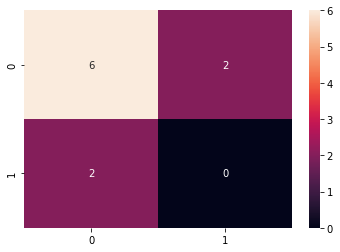

In [195]:
#load best model
#model = load_model('best_model.h5')
myModel.load_weights("best_model.h5")

Y_test_cat = to_categorical(Y_test)

scores = myModel.evaluate(lines_pad_x_test, Y_test_cat, verbose=0)
#predictions = myModel.predict_classes(X_test, verbose=0)
predScores = myModel.predict(lines_pad_x_test)
predictions = (predScores > 0.5).astype("int32")
predicted_labels = np.argmax(predictions, axis=1)

accuracy=accuracy_score(Y_test, predicted_labels)
if n_categories > 2:
    precision=precision_score(Y_test, predicted_labels, average='macro')
    recall=recall_score(Y_test, predicted_labels, average='macro')
    f1=f1_score(Y_test, predicted_labels, average='macro')
else:
    precision=precision_score(Y_test, predicted_labels, average='macro')
    recall=recall_score(Y_test, predicted_labels, average='macro')
    f1=f1_score(Y_test, predicted_labels, average='macro')
    roc_auc=roc_auc_score(Y_test, predicted_labels, average='macro')
f2=5*precision*recall / (4*precision+recall)

cm = confusion_matrix(Y_test, predicted_labels)
#print(cm)
sn.heatmap(cm, annot=True)
tn, fp, fn, tp = cm.ravel()

print("TP=",tp)
print("TN=",tn)
print("FP=",fp)
print("FN=",fn)

acc = ((tp+tn)/(tp+tn+fp+fn))

print("Accuracy:%.2f%%"%(acc*100))
print("Precision:%.2f%%"%(precision*100))
print("Recall:%.2f%%"%(recall*100))
print("F1 score:%.2f%%"%(f1*100))
print("Roc_Auc score:%.2f%%"%(roc_auc*100))
print("F2 score:%.2f%%"%(f2*100))
print(classification_report(Y_test, predicted_labels))

Export classification report

In [ ]:
# Create the path
path = os.path.join(root_path, 'results', model_variation.split("/")[-1], method, str(shuffle_seeder))

# Create directory if it doesn't exist
os.makedirs(path, exist_ok=True)

# Define the CSV file path
csv_file_path = os.path.join(path, f"{shuffle_seeder}.csv")

# Write data to CSV
data = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1,
    "f2": f2,
    "roc_auc": roc_auc
}

# Write to CSV
with open(csv_file_path, "w", newline="") as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=data.keys())
    writer.writeheader()
    writer.writerow(data)


Compute the average values of the classication metrics considering the results for all different seeders

In [164]:
# Define a dictionary to store cumulative sum of metrics
cumulative_metrics = defaultdict(float)
count = 0  # Counter to keep track of number of CSV files

# Iterate over all CSV files in the results folder
results_folder = os.path.join(root_path, "results", model_variation.split("/")[-1], method, str(shuffle_seeder))
for filename in os.listdir(results_folder):
    if filename.endswith(".csv"):
        csv_file_path = os.path.join(results_folder, filename)
        with open(csv_file_path, "r", newline="") as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                for metric, value in row.items():
                    cumulative_metrics[metric] += float(value)
        count += 1
        
# Compute average values
average_metrics = {metric: total / count for metric, total in cumulative_metrics.items()}

# Print average values 
print(average_metrics)

# Define the path for the average CSV file
avg_csv_file_path = os.path.join(root_path, "results", model_variation.split("/")[-1], method, "avg.csv")

# Write average metrics to CSV
with open(avg_csv_file_path, "w", newline="") as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=average_metrics.keys())
    writer.writeheader()
    writer.writerow(average_metrics)

{'accuracy': 0.2, 'precision': 0.2, 'recall': 1.0, 'f1': 0.33333333333333337, 'f2': 0.5555555555555556, 'roc_auc': 0.5}
